## Librarby Import

In [1]:
import pymongo

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import math
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.width', None)

In [2]:
# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["stock_data_db"]
collection = db["stock_data"]

# Fetch data from MongoDB
data=collection.find({})

# Convert document based database to pandas dataframe
df = pd.DataFrame(list(data))

# Extract the desired data from the document-converted dataframe
df = pd.DataFrame(df[df['symbol']=='NVDA']['technical_data'][0])

## Check Data Integrity

In [3]:
#Compute the missing value ratio 
missing_data = ((df.isnull().sum())/len(df))
missing_data = missing_data[missing_data.values > 0].sort_values()

if missing_data.empty:
    print('No missing values')    
else:
    #Visualize the missing value ratio 
    fig = plt.figure(figsize=(5,5), dpi = 100)
    sns.barplot(x = missing_data.index, y = missing_data.values) 
    plt.xticks(rotation=90)
    plt.title('Features Missing Ratio')
    plt.show()

No missing values


## Data Processing

In [4]:
# Add Timestamp column
df['timestamp'] = np.arange(len(df))
df = df.drop(columns=['date'])

# Convert columns with Alert to category
df["CandleStickType"] = df["CandleStickType"].astype('category')
alert_columns = df.columns[df.columns.str.contains('Alert')]
for column in alert_columns:
    df[column] = df[column].astype('category')

# Normalize the numeric data (excluding 'close')
scaler = MinMaxScaler()
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['close'])
df[numeric_df.columns] = scaler.fit_transform(numeric_df)

# Log transform the target variable (close)
df['close'] = np.log1p(df['close'])

# Encode categorical data
ohe = OneHotEncoder(drop='first')  # Optionally drop first to avoid multicollinearity
categorical_df = df.select_dtypes(include=['category'])
encoded_df = pd.DataFrame(ohe.fit_transform(categorical_df).toarray(), 
                          columns=ohe.get_feature_names_out(categorical_df.columns))

# Concatenate the encoded categorical data with the numeric data and 'close'
df = pd.concat([df[numeric_df.columns], encoded_df, df[['close']]], axis=1)

In [5]:
df

,open,high,low,volume,8EMA,13EMA,144EMA,169EMA,MACD,MACD_SIGNAL,MACD_HIST,atr,BodyDiff,close_t-1,close_t-2,close_t-3,169EMA_Upper,169EMA_Lower,timestamp,CandleStickType_red,MACD_Alert_0,MACD_Alert_1,Engulf_Alert_0,Engulf_Alert_1,dual_channel_Alert_0,dual_channel_Alert_1,382_Alert_1,close
0,0.016278,0.010949,0.013268,0.429679,0.011541,0.013287,0.024527,0.026618,0.276104,0.231796,0.464793,0.019623,5.533665e-02,0.016342,0.015659,0.017314,0.026618,0.026618,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.606351
1,0.011237,0.006783,0.011864,0.360017,0.010182,0.011921,0.023630,0.025759,0.275804,0.231293,0.465156,0.018618,9.536694e-03,0.010718,0.016342,0.015659,0.025759,0.025759,0.002004,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.603028
2,0.011788,0.007155,0.011510,0.275738,0.008578,0.010395,0.022701,0.024870,0.274831,0.230665,0.463972,0.017560,2.805638e-02,0.010356,0.010718,0.016342,0.024870,0.024870,0.004008,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.581491
3,0.011912,0.007751,0.011872,0.280470,0.007682,0.009316,0.021813,0.024018,0.275864,0.230402,0.467418,0.016561,9.314920e-03,0.008042,0.010356,0.010718,0.024018,0.024018,0.006012,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.595379
4,0.011160,0.008425,0.012661,0.272156,0.007598,0.008789,0.020989,0.023221,0.279193,0.230966,0.475205,0.015569,3.504277e-02,0.009529,0.008042,0.010356,0.023221,0.023221,0.008016,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.619173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.821869,0.845316,0.859968,0.144746,0.866459,0.881785,0.991601,0.990329,0.239250,0.217571,0.397385,0.999751,2.541845e-01,0.849874,0.779033,0.765926,0.990329,0.990329,0.991984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.788658
496,0.839257,0.838883,0.878224,0.051181,0.877498,0.887952,0.994206,0.993202,0.274741,0.219666,0.489618,0.995363,1.110304e-03,0.867888,0.849874,0.779033,0.993202,0.993202,0.993988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.788325
497,0.821481,0.825087,0.851580,0.058750,0.881678,0.890374,0.996409,0.995714,0.290972,0.225117,0.521221,0.990117,9.420481e-07,0.867566,0.867888,0.849874,0.995714,0.995714,0.995992,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.768818
498,0.832193,0.829892,0.855445,0.046507,0.882671,0.890981,0.998394,0.998027,0.297961,0.231103,0.526262,0.980477,2.852636e-01,0.848909,0.867566,0.867888,0.998027,0.998027,0.997996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.758663


## Machine Learning Model

### Base Model

MSE Baseline Score: 0.84145858


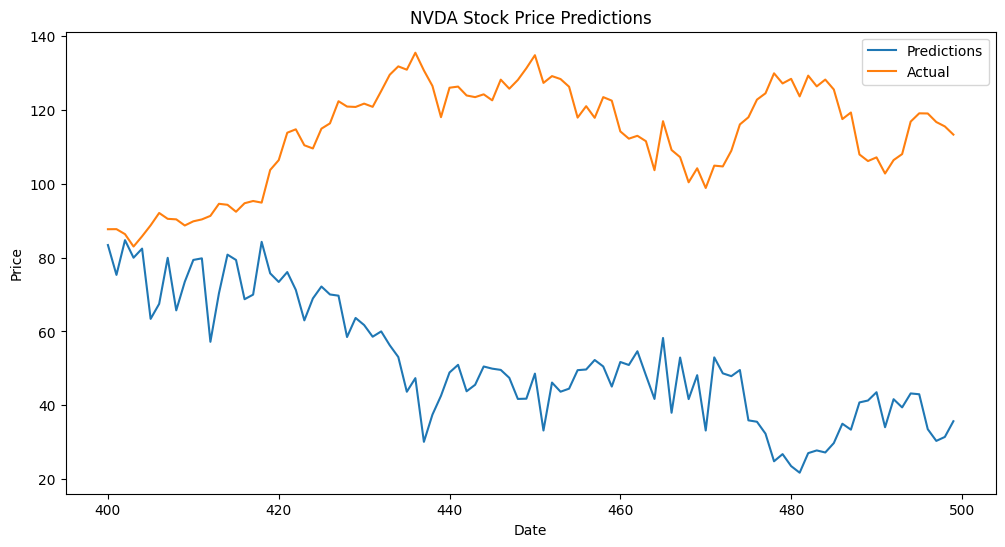

In [6]:
def base_score(df):

    X = df.copy()
    X = X.drop(['timestamp'], axis=1)
    
    # Split data into training and testing sets
    train_size = int(len(df) * 0.8)
    X_train = X[:train_size].drop('close', axis=1)
    y_train_data = X['close'][:train_size]
    X_test = X[train_size:].drop('close', axis=1)
    y_test_data = X['close'][train_size:]
    
    # Train the model
    kernel = kernels.RBF()
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(X_train, y_train_data)

    # Make predictions on the testing set
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_data, predictions)
    
    # Plot predictions and actual stock prices
    plt.figure(figsize=(12, 6))
    plt.plot(X_test.index, np.expm1(predictions), label='Predictions')
    plt.plot(X_test.index, np.expm1(y_test_data), label='Actual')
    plt.title('NVDA Stock Price Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    return mse

print(f"MSE Baseline Score: {base_score(df):.8}")

### Transformer Model

#### Data Loading

In [7]:
class TimeSeriesDataset(Dataset):
  def __init__(self, dataframe, window_size):

    self.window_size = window_size
    trade_days = dataframe['timestamp'].nunique()
    self.max_len = trade_days - window_size + 1

    self.windows = []
    self.targets = []

    features = torch.tensor(dataframe.drop(['close'],axis=1).iloc[:,:].values, dtype=torch.float32)
    targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)
    max_num_windows = min((len(features) - self.window_size + 1), self.max_len)

    # Genearate windows
    for i in range(max_num_windows):

      window_data_tensor = features[i:i + self.window_size]
      target = targets[i + self.window_size - 1]
      self.windows.append((window_data_tensor, target))
      self.targets.append(target)

  def __len__(self):
    return len(self.windows)

  def __getitem__(self, idx):
    if idx >= len(self.windows):
      raise IndexError("Index out of range")
    return self.windows[idx]

In [8]:

def train_test_split(df,train_index,test_index,window_size=30,batch_size=16):

    # Split the data into training and testing sets
    train_data = df[df['timestamp'].isin(train_index)]
    val_data = df[df['timestamp'].isin(test_index)]

    train_dataset = TimeSeriesDataset(train_data,window_size=window_size)
    val_dataset = TimeSeriesDataset(val_data,window_size=window_size)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
    
    return train_dataloader, val_dataloader

tscv = TimeSeriesSplit(n_splits=3)

for fold, (train_index, val_index) in enumerate(tscv.split(df['timestamp'].unique())):
    train_test_split(df,train_index,val_index)


#### Model Architecture

In [9]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=256):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

class TransformerModel(nn.Module):
  def __init__(self, input_dim, d_model, nhead, num_encoder_layers,
                num_decoder_layers, dim_feedforward, num_embeddings,
                embedding_dim, dropout):

    super(TransformerModel, self).__init__()
    self.h3_embedding_layer = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    self.linear_encoder = nn.Linear(input_dim + embedding_dim, d_model)
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dim_feedforward),
      nn.BatchNorm1d(dim_feedforward),
      nn.ReLU(),
      nn.Linear(dim_feedforward, d_model),
      nn.BatchNorm1d(d_model),
      nn.ReLU())
    self.linear_decoder = nn.Linear(d_model, 1)
    self.d_model = d_model

  def forward(self, x, h3_indices):
    # Validate h3_indices
    assert torch.all(h3_indices >= 0) and torch.all(h3_indices < self.h3_embedding_layer.num_embeddings), \
        f"Invalid h3_indices values: {h3_indices}"
        
    # Encode the input features
    x = self.linear_encoder(x) * math.sqrt(self.d_model)
    # Add positional encoding to input features
    x = self.pos_encoder(x)
    # Transformer expects inputs in the shape (S, N, E) -> (sequence_length, batch_size, d_model)
    x = x.transpose(0, 1)
    # Pass through the transformer
    transformer_output = self.transformer(x, x)

    # Apply feedforward network with BatchNorm1d
    batch_size, seq_len, feature_dim = transformer_output.size()
    transformer_output = transformer_output.contiguous().view(-1, feature_dim)
    # Apply feedforward network
    transformer_output = self.ffn(transformer_output)
    # Use the last time step for each sequence in the batch
    transformer_output = transformer_output.view(seq_len, batch_size, self.d_model).transpose(0, 1).contiguous()
    output = self.linear_decoder(transformer_output[-1])
    return output.squeeze(1)

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)

# Initialize the model
model = TransformerModel(input_dim= df.shape[1]-1, d_model=128, nhead=4, num_encoder_layers=3,
                          num_decoder_layers=3, dim_feedforward=512, num_embeddings=10, embedding_dim=4, dropout=0.1)
# Apply weight initialization                          
model.apply(init_weights)

# Set device to apple silicon if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found.")
else:
    print ("MPS device not found.")

MPS device found.


In [10]:
def train(self,train_dataloader,criterion,optimizer,epoch,device):
    self.model.train()

    # Initialize accumulators
    total_loss = 0
    self.model.train()

    # Using tqdm for training progress
    train_pbar = tqdm(enumerate(train_dataloader),
                    total=len(train_dataloader),
                    desc=f"Epoch {epoch + 1}/{self.epochs}")

    # Train over Batches
    for batch_idx, batch in train_pbar:
      x_batch, y_batch = batch
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      # Predict
      y_pred = self.model(x_batch)

      # Calculate regularization terms
      l1_regularization = torch.tensor(0.).to(device)
      l2_regularization = torch.tensor(0.).to(device)
      for param in self.model.parameters():
          l1_regularization += torch.norm(param, 1)
          l2_regularization += torch.norm(param, 2)

      # Compute Loss
      loss = criterion(y_pred, y_batch) + self.l1_lambda * l1_regularization + self.l2_lambda * l2_regularization

      loss.backward()
      optimizer.step()

      # Accumulate loss
      total_loss += loss.item()
      
      # Update progress bar
      train_pbar.set_postfix({'Batch Loss': f"{loss.item():.4f}"})
      # Add batch loss to TensorBoard
      self.writer.add_scalar('Batch Loss/Train', loss.item(), epoch * len(train_dataloader) + batch_idx)
      self.writer.add_scalar('Batch F2 Score/Train', epoch * len(train_dataloader) + batch_idx)
      self.writer.add_scalar('Batch Precision /Train', epoch * len(train_dataloader) + batch_idx)

    #  Calculate average loss
    avg_train_loss = total_loss / len(train_dataloader)

    return avg_train_loss

def validation(self,test_dataloader,criterion,scheduler,device):
    self.model.eval()

    # Initialize accumulators
    total_loss = 0

    with torch.no_grad():
      for batch in tqdm(test_dataloader, desc="Validating"):
        inputs, h3_idx, targets = batch
        inputs, h3_idx, targets = inputs.to(device), h3_idx.to(device), targets.to(device)
        # Predict
        y_pred = self.model(inputs, h3_idx)
        # Loss
        batch_loss = criterion(y_pred, targets)
        # Store Loss
        total_loss += batch_loss.item()

      # Compute average loss
      avg_loss = total_loss/len(test_dataloader)

      # Adaptive Learning rate
      if scheduler is not None:
        scheduler.step(avg_loss)

      return avg_loss

In [11]:
epochs = 10

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01,weight_decay=0.001)

tscv = TimeSeriesSplit(n_splits=4)
folds_val_results = {}
folds_train_results = {}

# Expanding Window Cross-Validation Folds
for fold, (train_index, val_index) in enumerate(tscv.split(df['timestamp'].unique())):
    train_dataloader, test_dataloader = train_test_split(df, train_index, val_index,fold)

    epoches_val_results = []
    epoches_train_results = []

    # Train on Each Fold
    for epoch in range(epochs):

        # Training
        avg_train_loss = train(train_dataloader,criterion,optimizer,epoch,device)
        # Validating
        avg_val_loss = validation(test_dataloader,criterion,device)

        print(f"Fold {fold+1}: Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}")
        print(f"Fold {fold+1}: Epoch [{epoch + 1}/{epochs}], Val Loss: {avg_val_loss:.4f}")

        # Record val loss and train loss for each epoch
        epoches_val_results.append(avg_val_loss)
        epoches_train_results.append(avg_train_loss)
        
    # Store train and eval results
    folds_val_results[fold] = epoches_val_results
    folds_train_results[fold] = epoches_train_results



IndexError: index -1 is out of bounds for dimension 0 with size 0